In [1]:
import os
import numpy as np
import pandas as pd
import functools

import geopandas as gpd
import rasterio
from rasterio.enums import Resampling, MergeAlg
from rasterio import features

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 

import sys
os.chdir(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\crop_rotation')

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Zone Labels**

(362, 896)


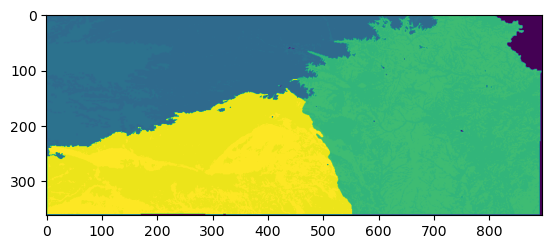

In [3]:
# Cluster Template
cluster = rasterio.open(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif').read(1)
print(cluster.shape)
new_width = cluster.shape[1]
new_height = cluster.shape[0]
plt.imshow(cluster)

**Crop Insurance Cause of Loss Data**

In [5]:
# Insurance Data
fp= r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/data_processing/final_processing/loss_type_per.shape" # state shape file. 
loss_type = gpd.read_file(fp)
loss_type.to_crs(4326, inplace = True)
print(loss_type.shape==cluster.shape)
loss_type.head(3)

False


,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,Cold Wet W,Cold Winte,Drought,...,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,geometry
0,20,20023,Kansas,cheyenne,05,2.145800,0.277993,0.008199,0.009869,0.493143,...,0.000439,0.036521,0.000000,0.285915,0.038090,0.016051,0.000898,0.012373,0.037265,"POLYGON ((-102.04981 39.57406, -102.04993 39.5..."
1,20,20153,Kansas,rawlins,05,2.213924,0.291303,0.004149,0.004017,0.622200,...,0.000078,0.029575,0.000676,0.139846,0.024056,0.012126,0.000000,0.003003,0.030883,"POLYGON ((-101.41391 39.56832, -101.41361 39.5..."
2,20,20089,Kansas,jewell,05,2.016403,0.249024,0.006806,0.021999,0.584490,...,0.005143,0.063787,0.006200,0.128203,0.021179,0.000459,0.001369,0.001115,0.005777,"POLYGON ((-98.50527 39.56760, -98.50530 39.567..."


In [6]:
# Convert Vector Geopandas to a List of Numpy Arrays in the Same Spatial Domain as Clusters
value_list = ['Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']

loss_list = []
template = rasterio.open(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif')

for i in value_list: 
    geom_value = ((geom,value) for geom, value in zip(loss_type.geometry, loss_type[i]))
    rasterized = features.rasterize(geom_value,
                                out_shape = template.shape,
                                transform = template.transform,
                                all_touched = True,
                                fill = -9999,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.float32)
    loss_list.append(rasterized) 

**Insurance Classifier Data**

In [36]:
# Irrigation Classifier
fp= r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\irrigation_classifier\KS_irrigation_focus2007_applicable2003_2012.shp" # state shape file. 
irr = gpd.read_file(fp)
irr.to_crs(4326, inplace = True)
print(irr.shape==cluster.shape)
print(irr.shape)
irr.head(3)

False
(11209, 3)


,Id,gridcode,geometry
0,1,1,"POLYGON ((-102.03954 39.97937, -102.04046 39.9..."
1,2,1,"POLYGON ((-101.53801 40.00006, -101.54207 40.0..."
2,4,1,"POLYGON ((-101.54528 39.98847, -101.54795 39.9..."


In [8]:
template = rasterio.open(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif')

geom_value = ((geom,value) for geom, value in zip(irr.geometry, irr['gridcode']))
irr_raster = features.rasterize(geom_value,
                            out_shape = template.shape,
                            transform = template.transform,
                            all_touched = True,
                            fill = -9999,   # background value
                            merge_alg = MergeAlg.replace,
                            dtype = np.float32)

True

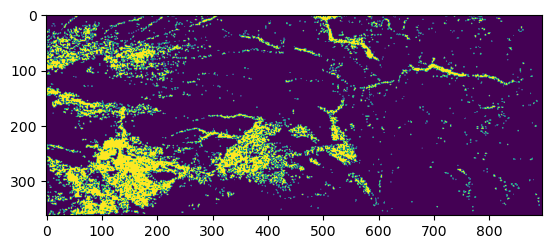

In [9]:
plt.imshow(irr_raster)
irr_raster.shape == cluster.shape

**Crop Frequency Data**

In [10]:
# Crop Rotation Data
ks_2022= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2022wgs84_ks_scaled.tif").read(1)
ks_2021= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2021wgs84_ks_scaled.tif").read(1)
ks_2020= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2020wgs84_ks_scaled.tif").read(1)     
ks_2019= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2019wgs84_ks_scaled.tif").read(1)
ks_2018= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2018wgs84_ks_scaled.tif").read(1)
ks_2017= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2017wgs84_ks_scaled.tif").read(1)
ks_2016= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2016wgs84_ks_scaled.tif").read(1)    
ks_2015= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2015wgs84_ks_scaled.tif").read(1)
ks_2014= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2014wgs84_ks_scaled.tif").read(1)
ks_2013= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2013wgs84_ks_scaled.tif").read(1)

rotation = np.stack(( ks_2022, ks_2021, ks_2020, ks_2019, ks_2018, ks_2017, ks_2016, ks_2015, ks_2014, ks_2013))

In [11]:
# Function to mask for specific crop values
def CropCount(np_array, vals):
    mask = functools.reduce(np.logical_or, (np_array==val for val in vals))
    non_crop = (np.where(mask, 1,0)).astype(dtype=np.uint8)
    return non_crop 

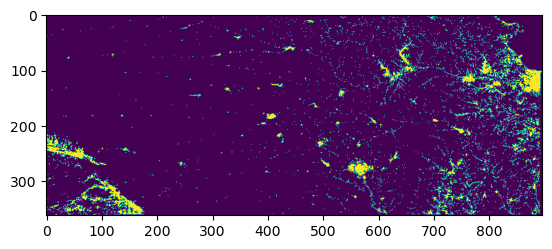

In [12]:
# Create a Boolean for Non crop and Non crop plus grass values
ks_non_crop = CropCount(ks_2022,[63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 190, 195])
ks_non_crop_grass = CropCount(ks_2022,[63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 176,  190, 195])
plt.imshow(ks_non_crop)

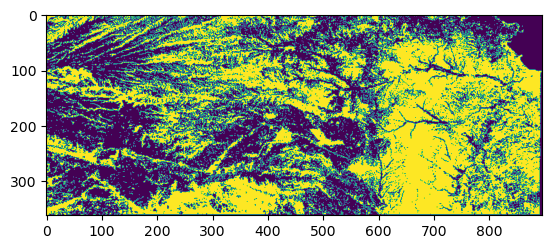

In [13]:
plt.imshow(ks_non_crop_grass)

In [14]:
# Get top 10 crops by area
mask = (ks_non_crop == 1) 
unique, counts = np.unique(ks_2022[~mask], return_counts=True)
unq = pd.DataFrame(counts,unique)
unq
unq.sort_values(by=[0])

,0
44.0,1
43.0,2
254.0,3
53.0,3
57.0,5
21.0,6
238.0,6
59.0,9
31.0,26
225.0,29


In [15]:
# Calculate refrequency of crop planted for the 10 year period
wheat = [CropCount(r, [24]) for r in rotation]
wheat = sum(wheat)

corn = [CropCount(r, [1]) for r in rotation]
corn = sum(corn)

soybeans = [CropCount(r, [5]) for r in rotation]
soybeans = sum(soybeans)

fallow = [CropCount(r, [61]) for r in rotation]
fallow = sum(fallow)

sorghum = [CropCount(r, [4]) for r in rotation]
sorghum = sum(sorghum)

wht_soy = [CropCount(r, [26]) for r in rotation]
wht_soy= sum(wht_soy)

alfalfa = [CropCount(r, [36]) for r in rotation]
alfalfa= sum(alfalfa)

other_hay = [CropCount(r, [37]) for r in rotation]
other_hay= sum(other_hay)

triticale = [CropCount(r, [205]) for r in rotation]
triticale= sum(triticale)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

grassland = [CropCount(r, [176]) for r in rotation]
grassland = sum(grassland)

**Macro Zone and Macro-Micro Validation Data Set**

In [45]:
# This does not include grassland
# Create mask 
mask_macro = (cluster == 0) | (ks_non_crop_grass == 1) |(loss_list[0] ==-9999) |(irr_raster ==1)

cluster_m = cluster[~mask_macro]

crop_features =[wheat, corn, soybeans, fallow, sorghum, wht_soy, alfalfa, other_hay, triticale, cotton]
feature_list = crop_features+loss_list
crop_features_m = [f[~mask_macro] for f in feature_list] 

In [47]:
# This does include grassland
# Create mask 
mask_macro = (cluster == 0) | (ks_non_crop == 1) |(loss_list[0] ==-9999) |(irr_raster ==1)

cluster_m = cluster[~mask_macro]

crop_features =[wheat, corn, soybeans, fallow, sorghum, wht_soy, alfalfa, other_hay, triticale, cotton, grassland]
feature_list = crop_features+loss_list
crop_features_m = [f[~mask_macro] for f in feature_list]

**Micro Zone Validation Data Set**

In [17]:
# Create mask for each of the macro areas with grassland

mask = (ks_non_crop ==0) & (cluster == 11) &(irr_raster ==-9999) | (ks_non_crop ==0) & (cluster == 12) & (irr_raster ==-9999)
zone1 = cluster[mask]
grass1 = grassland[mask]
loss_list1 = [f[mask] for f in loss_list] 

mask =(ks_non_crop ==0) & (cluster == 21) & (irr_raster ==-9999) | (ks_non_crop ==0) & (cluster == 22)  & (irr_raster ==-9999)
zone2 = cluster[mask]
grass2 = grassland[mask]
loss_list2 = [f[mask] for f in loss_list] 

mask = (ks_non_crop ==0) & (cluster == 31)  & (irr_raster ==-9999)| (ks_non_crop ==0) & (cluster == 32)  & (irr_raster ==-9999)
zone3 = cluster[mask]
grass3 = grassland[mask]
loss_list3 = [f[mask] for f in loss_list] 

**Function for Multinomial Logistic Regression**

In [18]:
def MultiNomial (x,y, class_weights, empty_dic):
    X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)

    # Select Optimal Model Parameters
    model = LogisticRegression() 

    # Set a CV to be utilized
    cv = 10

    # Set Paramters
    parameters = {'penalty' : ['l2',  'none'],
                  'solver' : ['lbfgs',  'newton-cg', 'sag', 'saga'],
                  'max_iter':[500, 1000],
                  'multi_class':['multinomial'], 
                  'class_weight':[class_weight], 
                 }
    params_ = GridSearchCV(estimator=model, param_grid = parameters, cv = cv, n_jobs=-1)
    params_.fit(X_train, y_train)
    print(params_.best_params_)
    empty_dic['parameters'] = params_.best_params_
    
    # Evaluate Model
    scores = cross_validate(LogisticRegression(**params_.best_params_), X_test, y_test, cv = 10,
               scoring=['r2', 'neg_mean_squared_error', 'accuracy', 'mutual_info_score'])
    for key,vals in scores.items():
        print("Average for {} is {}".format(key,round(np.mean(vals),2)))
    empty_dic['scores'] = scores
        
    # Classification Report 
    logmodel_macro = LogisticRegression(**params_.best_params_, random_state=2) 
    logmodel_macro.fit(X_train, y_train)

    predictions=logmodel_macro.predict(X_test)
    empty_dic['y_trues'] = y_test
    empty_dic['y_preds']=  predictions
    empty_dic['model'] = logmodel_macro 
    
    print(classification_report(y_test,  predictions))

**Macro Zone Validation w/Grassland**

In [48]:
y = np.round(cluster_m/10,0) # reduce to classes 1, 2, 3
y = y.astype(int).astype(str) # change to categorical variable 

class_weight = {'1':np.count_nonzero(y== '1')/np.count_nonzero(y),'2':np.count_nonzero(y== '2')/np.count_nonzero(y), '3':np.count_nonzero(y== '3')/np.count_nonzero(y)} # class weights

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 

X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)

macro_results = {}
macro_results['indices_train'] = indices_train
macro_results['indices_test'] = indices_test

MultiNomial (X,y, class_weight, macro_results)

{'class_weight': {'1': 0.3329460534999427, '2': 0.4321963903938794, '3': 0.2348575561061779}, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
Average for fit_time is 1.22
Average for score_time is 0.02
Average for test_r2 is 0.45
Average for test_neg_mean_squared_error is -0.3
Average for test_accuracy is 0.87
Average for test_mutual_info_score is 0.62
              precision    recall  f1-score   support

           1       0.86      0.91      0.89     21063
           2       0.88      0.96      0.92     27342
           3       0.85      0.63      0.72     14857

    accuracy                           0.87     63262
   macro avg       0.86      0.84      0.84     63262
weighted avg       0.87      0.87      0.86     63262



**Macro Zone Validation w/out Grassland**

In [46]:
y = np.round(cluster_m/10,0) # reduce to classes 1, 2, 3
y = y.astype(int).astype(str) # change to categorical variable 

class_weight = {'1':np.count_nonzero(y== '1')/np.count_nonzero(y),'2':np.count_nonzero(y== '2')/np.count_nonzero(y), '3':np.count_nonzero(y== '3')/np.count_nonzero(y)} # class weights

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 

X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)

macro_results = {}
macro_results['indices_train'] = indices_train
macro_results['indices_test'] = indices_test

MultiNomial (X,y, class_weight, macro_results)

{'class_weight': {'1': 0.3960008473561567, '2': 0.3379201090510532, '3': 0.2660790435927901}, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'saga'}
Average for fit_time is 5.32
Average for score_time is 0.01
Average for test_r2 is 0.51
Average for test_neg_mean_squared_error is -0.32
Average for test_accuracy is 0.87
Average for test_mutual_info_score is 0.63
              precision    recall  f1-score   support

           1       0.85      0.94      0.89     10749
           2       0.90      0.91      0.91      9173
           3       0.89      0.72      0.79      7222

    accuracy                           0.87     27144
   macro avg       0.88      0.86      0.86     27144
weighted avg       0.88      0.87      0.87     27144



**All Micro-Macro Zone Validation**

In [35]:
#This includes grassland as a variable 

y = cluster_m.astype(int).astype(str) # change to categorical variable 

class_weight = {'11':np.count_nonzero(y== '11')/np.count_nonzero(y),'12':np.count_nonzero(y== '12')/np.count_nonzero(y), 
                '21':np.count_nonzero(y== '21')/np.count_nonzero(y),  '22':np.count_nonzero(y== '22')/np.count_nonzero(y), 
                '31':np.count_nonzero(y== '31')/np.count_nonzero(y),  '32':np.count_nonzero(y== '32')/np.count_nonzero(y), } # class weights

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

# This includes grassland w/24 variables
X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)
X = MinMaxScaler().fit_transform(X) 

X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)

macro_results = {}
macro_results['indices_train'] = indices_train
macro_results['indices_test'] = indices_test

MultiNomial (X,y, class_weight, macro_results)

{'class_weight': {'11': 0.24512047169102974, '12': 0.08782558180891296, '21': 0.20139341703319938, '22': 0.23080297336068004, '31': 0.16505629389006785, '32': 0.06980126221611005}, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs'}
Average for fit_time is 12.34
Average for score_time is 0.02
Average for test_r2 is 0.4
Average for test_neg_mean_squared_error is -33.73
Average for test_accuracy is 0.65
Average for test_mutual_info_score is 0.7
              precision    recall  f1-score   support

          11       0.73      0.93      0.82     15507
          12       0.88      0.39      0.54      5556
          21       0.64      0.49      0.55     12740
          22       0.58      0.76      0.66     14601
          31       0.62      0.69      0.65     10442
          32       0.88      0.06      0.12      4416

    accuracy                           0.65     63262
   macro avg       0.72      0.55      0.56     63262
weighted avg       0.68      0.6

In [22]:
# Merge Back with Cluster For Plotting 
pred_array =np.full(y.shape,  -9999)
true_array =np.full(y.shape,  -9999)
test_inds = tuple(zip(* macro_results['indices_test']))#tuple(zip(*indices_test))
train_inds = tuple(zip(* macro_results['indices_train']))#tuple(zip(*indices_train))

pred_array[test_inds]=  macro_results['y_preds'] #predictions_log_macro 
pred_array[train_inds]=  -9999

true_array[test_inds]= macro_results['y_trues']#y_test
true_array[train_inds]=  -9999

pred_macro =np.full(cluster.shape, -9999)
actual_macro =np.full(cluster.shape,  -9999)

mask_idx = np.argwhere(mask_macro==False)
mask_idx= tuple(zip(*mask_idx))

pred_macro[mask_idx] =  pred_array.astype(int)
actual_macro[mask_idx] =  true_array.astype(int)

In [23]:
# Write to Shape Files for Plots

# Macro Predictions
file_str= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/pred_macro.tif'
rasterfn = r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif'
array = pred_macro
array2raster(file_str,rasterfn,array)

# Macro Ground Truth
file_str= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/actual_macro.tif'
rasterfn = r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\cluster.tif'
array = actual_macro
array2raster(file_str,rasterfn,array)

**Micro Cluster Validation for Zone 1**

In [27]:
# Zone 1 - Micro Validation
y = zone1.astype(str)

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((grass1, loss_list1[0].flatten(),loss_list1[1].flatten(),loss_list1[2].flatten(),loss_list1[3].flatten(), loss_list1[4].flatten(), loss_list1[5].flatten(), 
              loss_list1[6].flatten(),loss_list1[7].flatten(), loss_list1[8].flatten(),loss_list1[9].flatten(), loss_list1[10].flatten(), loss_list1[11].flatten(), 
              loss_list1[12].flatten()), axis=1)

X = MinMaxScaler().fit_transform(X) 

# Select Optimal Model Parameters
class_weight = {'11':np.count_nonzero(y== '11')/np.count_nonzero(y),'12':np.count_nonzero(y== '12')/np.count_nonzero(y)} 

macro1_micro_results = {}

MultiNomial (X,y, class_weight, macro1_micro_results)

{'class_weight': {'11': 0.7362167808097233, '12': 0.2637832191902767}, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Average for fit_time is 0.39
Average for score_time is 0.01
Average for test_r2 is 0.27
Average for test_neg_mean_squared_error is -0.14
Average for test_accuracy is 0.86
Average for test_mutual_info_score is 0.17
              precision    recall  f1-score   support

          11       0.84      0.98      0.91     15507
          12       0.90      0.50      0.64      5556

    accuracy                           0.85     21063
   macro avg       0.87      0.74      0.77     21063
weighted avg       0.86      0.85      0.84     21063



**Micro Cluster Validation for Zone 2**

In [25]:
# Zone 2 - Micro Validation
y = zone2.astype(str)

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((grass2, loss_list2[0].flatten(),loss_list2[1].flatten(),loss_list2[2].flatten(),loss_list2[3].flatten(), loss_list2[4].flatten(), loss_list2[5].flatten(), 
              loss_list2[6].flatten(),loss_list2[7].flatten(), loss_list2[8].flatten(),loss_list2[9].flatten(), loss_list2[10].flatten(), loss_list2[11].flatten(), 
              loss_list2[12].flatten()), axis=1)

macro2_micro_results = {}

# Select Optimal Model Parameters
class_weight = {'21':np.count_nonzero(y== '21')/np.count_nonzero(y),'22':np.count_nonzero(y== '22')/np.count_nonzero(y)} 

MultiNomial (X,y, class_weight, macro2_micro_results)

{'class_weight': {'21': 0.465976628934038, '22': 0.534023371065962}, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
Average for fit_time is 1.22
Average for score_time is 0.01
Average for test_r2 is -0.37
Average for test_neg_mean_squared_error is -0.34
Average for test_accuracy is 0.66
Average for test_mutual_info_score is 0.05
              precision    recall  f1-score   support

          21       0.68      0.52      0.59     12741
          22       0.65      0.78      0.71     14601

    accuracy                           0.66     27342
   macro avg       0.66      0.65      0.65     27342
weighted avg       0.66      0.66      0.65     27342



**Micro Cluster Validation for Zone 3**

In [26]:
y = zone3.astype(str)

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = grass3.reshape(-1, 1)

X = np.stack((grass3, loss_list3[0].flatten(),loss_list3[1].flatten(),loss_list3[2].flatten(),loss_list3[3].flatten(), loss_list3[4].flatten(), loss_list3[5].flatten(), 
              loss_list3[6].flatten(),loss_list3[7].flatten(), loss_list3[8].flatten(),loss_list3[9].flatten(), loss_list3[10].flatten(), loss_list3[11].flatten(), 
              loss_list3[12].flatten()), axis=1)

macro3_micro_results = {}

# Select Optimal Model Parameters
class_weight = {'31':np.count_nonzero(y== '31')/np.count_nonzero(y),'32':np.count_nonzero(y== '32')/np.count_nonzero(y)} 


MultiNomial (X,y, class_weight, macro3_micro_results)

{'class_weight': {'31': 0.7027932020864883, '32': 0.2972067979135117}, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'sag'}
Average for fit_time is 2.95
Average for score_time is 0.0
Average for test_r2 is -0.21
Average for test_neg_mean_squared_error is -0.25
Average for test_accuracy is 0.75
Average for test_mutual_info_score is 0.04
              precision    recall  f1-score   support

          31       0.74      0.98      0.84     10442
          32       0.82      0.18      0.29      4416

    accuracy                           0.74     14858
   macro avg       0.78      0.58      0.57     14858
weighted avg       0.76      0.74      0.68     14858

